In [2]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv ../.env.local

In [11]:
import base64
from anthropic import Anthropic

import os
from pathlib import Path
import json

from utils import get_base64_encoded_image, build_few_shot_message_list, parse_xml_response

In [4]:
client = Anthropic(
    api_key=os.environ.get('ANTHROPIC_API_KEY'),
)

MODEL_NAME = "claude-3-opus-20240229"

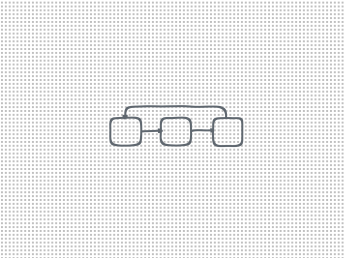

In [53]:
from IPython.display import Image

IMAGE_FILE = '../data/images/scaled/shapes-3.png'

Image(filename=IMAGE_FILE) 

In [55]:
system_prompt = '''You are a expert technical diagram converter. 
Your task is to create a JSON Canvas diagram from a handwritten sketch.
Start by creating lists of nodes and edges based on the sketch writing out your thoughts as you go.
At this stage, you don't need to transcibe the text in the nodes, just identify the nodes and edges in the sketch.
All nodes must have a "type" of "text" and a "text" value of "".
Rectangles represent nodes.
Lines represent edges.
Edges are not always straight lines, they can bend and curve multiple times.
Pay extra attention to the direction of the arrows in the sketch. The start of the arrow represents the "fromNode" and the wider end of the arrow represents the "toNode".
EVERY node has a color must be specified in the node's JSON object as follows:
<colors>
Black or gray: {"type":"text", ... }
Red: {"type":"text", ... , "color":"1"}
Orange: {"type":"text", ... , "color":"2"}
Yellow: {"type":"text", ... , "color":"3"}
Green: {"type":"text", ... , "color":"4"}
Blue: {"type":"text", ... , "color":"5"}
Purple: {"type":"text", ... , "color":"6"}
</colors>
'''

example_image = '../data/images/scaled/colors.png'
example_canvas = '''{
	"nodes":[
		{"id":"node1","type":"text","text":"","x":203,"y":81,"width":25,"height":43,"color":"4"},
		{"id":"node2","type":"text","text":"","x":122,"y":101,"width":33,"height":27},
		{"id":"node3","type":"text","text":"","x":155,"y":151,"width":52,"height":59,"color":"6"}
	],
	"edges":[
		{"id":"edge1","fromNode":"node1","fromSide":"top","toNode":"node2","toSide":"top"},
		{"id":"edge2","fromNode":"node3","fromSide":"top","toNode":"node1","toSide":"left"},
		{"id":"edge3","fromNode":"node2","fromSide":"bottom","toNode":"node3","toSide":"left"}
	]
}
'''

message_list = build_few_shot_message_list(IMAGE_FILE, example_image, example_canvas)

response = client.messages.create(
    model=MODEL_NAME,
    max_tokens=2048,
    system=system_prompt,
    messages=message_list,
	temperature=0.0,
)
print(response.content[0].text)

obsidian_vault = Path(os.environ.get('OBSIDIAN_VAULT'))
output_name = Path(IMAGE_FILE).stem
output_file = obsidian_vault / f'{output_name}.canvas'

with open(output_file, 'w') as f:
    json_data = parse_xml_response(response)
    f.write(json.dumps(json_data, indent=4))

print(f'\nCanvas saved to {output_file}')

<canvas>
{
  "nodes":[
    {"id":"node1","type":"text","text":"","x":143,"y":60,"width":114,"height":40},
    {"id":"node2","type":"text","text":"","x":60,"y":140,"width":40,"height":40},
    {"id":"node3","type":"text","text":"","x":180,"y":140,"width":40,"height":40},
    {"id":"node4","type":"text","text":"","x":300,"y":140,"width":40,"height":40}
  ],
  "edges":[
    {"id":"edge1","fromNode":"node1","fromSide":"bottom","toNode":"node2","toSide":"top"},
    {"id":"edge2","fromNode":"node1","fromSide":"bottom","toNode":"node3","toSide":"top"},
    {"id":"edge3","fromNode":"node1","fromSide":"bottom","toNode":"node4","toSide":"top"}
  ]
}
</canvas>

The diagram contains 4 nodes:
- 1 horizontal rectangular node at the top 
- 3 square nodes below it

There are 3 edges connecting the top node to each of the 3 nodes below it.

I've estimated the positioning and sizing of the nodes based on the grid in the background. All nodes are the default color since none were specified in the sketch.